<a href="https://colab.research.google.com/github/Karthik0505/Assignment/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd

# Data Extraction
import requests
from bs4 import BeautifulSoup

# NLP Models
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer

# Semantic Search
import faiss

# Recommendation System
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

# Web Interface
import streamlit as st

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install faiss.cpu
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00


In [4]:
# arXiv data

import requests
import pandas as pd
import re
import time

# Function to extract specific tags from arXiv response
def extract_tag(data, tag):
    try:
        pattern = f"<{tag}>(.*?)</{tag}>"
        match = re.search(pattern, data, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            return None
    except Exception as e:
        print(f"Error extracting {tag}: {e}")
        return None

# Function to extract and clean authors from arXiv response
def extract_authors(data):
    try:
        authors = re.findall(r'<author>\s*<name>(.*?)</name>\s*</author>', data, re.DOTALL)
        cleaned_authors = [author.strip() for author in authors]
        return ", ".join(cleaned_authors)
    except Exception as e:
        print(f"Error extracting authors: {e}")
        return None

# Function to fetch papers from arXiv
def fetch_arxiv_papers(categories, max_results_per_query=200, total_papers_per_category=1000):
    base_url = "http://export.arxiv.org/api/query?"
    all_papers = []

    for category in categories:
        print(f"Fetching papers for category: {category}")
        num_papers_fetched = 0

        while num_papers_fetched < total_papers_per_category:
            start = num_papers_fetched
            query = f"search_query=cat:{category}&start={start}&max_results={max_results_per_query}&sortBy=submittedDate&sortOrder=descending"
            url = base_url + query
            response = requests.get(url)

            if response.status_code != 200:
                print(f"Failed to fetch data for category {category}. Status Code: {response.status_code}")
                break

            papers = response.text.split('<entry>')[1:]
            if not papers:
                print(f"No more papers found for category {category}.")
                break

            for paper in papers:
                title = extract_tag(paper, 'title')
                abstract = extract_tag(paper, 'summary')
                authors = extract_authors(paper)
                published_date = extract_tag(paper, 'published')
                paper_id = extract_tag(paper, 'id')

                all_papers.append({
                    "Category": category,
                    "Title": title,
                    "Abstract": abstract,
                    "Authors": authors,
                    "Published Date": published_date,
                    "DOI/URL": paper_id,
                    "Site": "arXiv"
                })
                num_papers_fetched += 1

                if num_papers_fetched >= total_papers_per_category:
                    break

            time.sleep(1)  # Rate limiting to avoid overloading the API

        print(f"Total papers fetched from arXiv for {category}: {num_papers_fetched}")

    return pd.DataFrame(all_papers)

arxiv_categories = [
    'cs.AI', 'cs.CL', 'math.ST', 'econ.EM', 'physics.gen-ph',
    'q-bio', 'cs.LG', 'q-bio.CB', 'cs.RO'
]

arxiv_papers_df = fetch_arxiv_papers(arxiv_categories, max_results_per_query=200, total_papers_per_category=1000)

arxiv_papers_df.to_csv("arxiv_papers.csv", index=False)
print(f"arXiv papers saved to arxiv_papers.csv")

Fetching papers for category: cs.AI
No more papers found for category cs.AI.
Total papers fetched from arXiv for cs.AI: 400
Fetching papers for category: cs.CL
Total papers fetched from arXiv for cs.CL: 1000
Fetching papers for category: math.ST
Total papers fetched from arXiv for math.ST: 1000
Fetching papers for category: econ.EM
Total papers fetched from arXiv for econ.EM: 1000
Fetching papers for category: physics.gen-ph
Total papers fetched from arXiv for physics.gen-ph: 1000
Fetching papers for category: q-bio
Total papers fetched from arXiv for q-bio: 1000
Fetching papers for category: cs.LG
No more papers found for category cs.LG.
Total papers fetched from arXiv for cs.LG: 200
Fetching papers for category: q-bio.CB
Total papers fetched from arXiv for q-bio.CB: 1000
Fetching papers for category: cs.RO
Total papers fetched from arXiv for cs.RO: 1000
arXiv papers saved to arxiv_papers.csv


In [5]:
arXiv = pd.read_csv("arxiv_papers.csv")

In [6]:
arXiv.head(10)

Category                                              Title  \
0    cs.AI  Action-Agnostic Point-Level Supervision for Te...   
1    cs.AI  Adversarial Attack and Defense for LoRa Device...   
2    cs.AI  Open RAN-Enabled Deep Learning-Assisted Mobili...   
3    cs.AI  Aviary: training language agents on challengin...   
4    cs.AI  PyG-SSL: A Graph Self-Supervised Learning Toolkit   
5    cs.AI  Facilitating large language model Russian adap...   
6    cs.AI   On Parallel External-Memory Bidirectional Search   
7    cs.AI  Exploring and Controlling Diversity in LLM-Age...   
8    cs.AI  Towards Effective Discrimination Testing for G...   
9    cs.AI  Toward Intelligent and Secure Cloud: Large Lan...   

                                            Abstract  \
0  We propose action-agnostic point-level (AAPL) ...   
1  LoRa provides long-range, energy-efficient com...   
2  Connected Vehicles (CVs) can leverage the uniq...   
3  Solving complex real-world tasks requires cycl...   
4  Graph Self-Supervised Learning (SSL) has emerg...   
5  Rapid advancements of large language model (LL...   
6  Parallelization and External Memory (PEM) tech...   
7  Diversity is a critical aspect of multi-agent ...   
8  Generative AI (GenAI) models present new chall...   
9  The rapid evolution of cloud computing technol...   

                                             Authors        Published Date  \
0  Shuhei M. Yoshida, Takashi Shibata, Makoto Ter...  2024-12-30T18:59:55Z   
1                      Yalin E. Sagduyu, Tugba Erpek  2024-12-30T18:43:21Z   
2                         Maria Barbosa, Kelvin Dias  2024-12-30T18:41:29Z   
3  Siddharth Narayanan, James D. Braza, Ryan-Rhys...  2024-12-30T18:33:28Z   
4  Lecheng Zheng, Baoyu Jing, Zihao Li, Zhichen Z...  2024-12-30T18:32:05Z   
5              Mikhail Tikhomirov, Daniil Chernyshev  2024-12-30T18:15:45Z   
6  ior Siag, Shahaf S. Shperberg, Ariel Felner, N...  2024-12-30T17:29:51Z   
7         KuanChao Chu, Yi-Pei Chen, Hideki Nakayama  2024-12-30T17:25:58Z   
8  Thomas P. Zollo, Nikita Rajaneesh, Richard Zem...  2024-12-30T16:09:33Z   
9      Yuyang Zhou, Guang Cheng, Kang Du, Zihan Chen  2024-12-30T16:09:28Z   

                             DOI/URL   Site  
0  http://arxiv.org/abs/2412.21205v1  arXiv  
1  http://arxiv.org/abs/2412.21164v1  arXiv  
2  http://arxiv.org/abs/2412.21161v1  arXiv  
3  http://arxiv.org/abs/2412.21154v1  arXiv  
4  http://arxiv.org/abs/2412.21151v1  arXiv  
5  http://arxiv.org/abs/2412.21140v1  arXiv  
6  http://arxiv.org/abs/2412.21104v1  arXiv  
7  http://arxiv.org/abs/2412.21102v1  arXiv  
8  http://arxiv.org/abs/2412.21052v1  arXiv  
9  http://arxiv.org/abs/2412.21051v1  arXiv

In [7]:
len(arXiv)

7600

In [8]:
# semantic search api


categories = {
    'cs.AI': "Artificial Intelligence Machine Learning Deep Learning Neural Networks",
    'cs.CL': "Natural Language Processing NLP Text Mining",
    'math.ST': "Statistical Theory Probability Bayesian Networks",
    'econ.EM': "Econometrics Economic Modeling Data-driven Economics",
    'physics.gen-ph': "Physics Quantum Physics Computational Physics",
    'q-bio': "Bioinformatics Computational Biology Gene Data Analysis",
    'cs.LG': "Learning Theory Supervised Learning Unsupervised Learning",
    'q-bio.CB': "Cell Biology Cellular Networks Cell Modeling",
    'cs.RO': "Robotics Autonomous Systems Robot Control"
}

# Function to fetch papers from Semantic Scholar
def fetch_papers(query, category, max_results=2000, api_key=None):
    """
    Fetch papers from Semantic Scholar for a specific query with rate-limiting handling.

    Parameters:
        query (str): The search query string.
        category (str): The category name to include in the output.
        max_results (int): Maximum number of papers to fetch.
        api_key (str): Semantic Scholar API key (optional).

    Returns:
        list[dict]: List of paper metadata with the category included.
    """
    base_url = "https://api.semanticscholar.org/graph/v1/paper/search"
    headers = {"User-Agent": "PaperFetcherBot/1.0"}
    if api_key:
        headers["x-api-key"] = api_key

    batch_size = 100
    papers = []

    for offset in range(0, max_results, batch_size):
        params = {
            "query": query,
            "offset": offset,
            "limit": batch_size,
            "fields": "title,abstract,authors,year,url"
        }

        try:
            response = requests.get(base_url, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                if "data" not in data or not data["data"]:
                    print("No more papers found or reached the API limit.")
                    break

                for paper in data["data"]:
                    title = paper.get("title", "No Title")
                    abstract = paper.get("abstract", "No Abstract")
                    authors = ", ".join([author["name"] for author in paper.get("authors", [])])
                    published_date = paper.get("year", "No Year")
                    paper_url = paper.get("url", "No URL")

                    papers.append({
                        "Category": category,
                        "Title": title,
                        "Abstract": abstract,
                        "Authors": authors,
                        "Published Date": published_date,
                        "DOI/URL": paper_url,
                        "Site": "Semantic Scholar"
                    })

                print(f"Fetched {len(data['data'])} papers, total: {len(papers)}")
            elif response.status_code == 429:
                print("Rate limit exceeded. Waiting for 60 seconds...")
                time.sleep(60)
                continue
            else:
                print(f"Error: {response.status_code}, Message: {response.text}")
                break

            time.sleep(2)
        except requests.RequestException as e:
            print(f"Request failed: {e}")
            break

    return papers

max_results_per_category = 300
api_key = None
all_papers = []

for category, query in categories.items():
    print(f"Fetching papers for category: {category} - {query}")
    papers = fetch_papers(query, category, max_results=max_results_per_category, api_key=api_key)
    all_papers.extend(papers)

columns_order = ["Category", "Title", "Abstract", "Authors", "Published Date", "DOI/URL", "Site"]
df = pd.DataFrame(all_papers, columns=columns_order)

if not df.empty:
    df.to_csv("semantic_scholar_2000_papers.csv", index=False)
    print("Data saved to semantic_scholar_2000_papers.csv")
else:
    print("No papers fetched.")

print(f"Total papers fetched: {len(all_papers)}")

Fetching papers for category: cs.AI - Artificial Intelligence Machine Learning Deep Learning Neural Networks
Fetched 100 papers, total: 100
Fetched 100 papers, total: 200
Fetched 100 papers, total: 300
Fetching papers for category: cs.CL - Natural Language Processing NLP Text Mining
Fetched 100 papers, total: 100
Fetched 100 papers, total: 200
Fetched 100 papers, total: 300
Fetching papers for category: math.ST - Statistical Theory Probability Bayesian Networks
Fetched 100 papers, total: 100
Fetched 100 papers, total: 200
Fetched 100 papers, total: 300
Fetching papers for category: econ.EM - Econometrics Economic Modeling Data-driven Economics
Fetched 100 papers, total: 100
Fetched 100 papers, total: 200
Fetched 100 papers, total: 300
Fetching papers for category: physics.gen-ph - Physics Quantum Physics Computational Physics
Fetched 100 papers, total: 100
Fetched 100 papers, total: 200
Fetched 100 papers, total: 300
Fetching papers for category: q-bio - Bioinformatics Computational Bi

In [9]:
semantic = pd.read_csv("semantic_scholar_2000_papers.csv")

In [10]:
semantic.head()

Category                                              Title  \
0    cs.AI  What Is Machine Learning, Artificial Neural Ne...   
1    cs.AI  MATLAB Deep Learning With Machine Learning Neu...   
2    cs.AI  Artificial intelligence, machine learning, neu...   
3    cs.AI  Quantum machine learning-using quantum computa...   
4    cs.AI  Artificial intelligence, machine learning, and...   

                                            Abstract  \
0  Machine learning (ML), artificial neural netwo...   
1  Machine Learning Models and Algorithms for Big...   
2                                                NaN   
3  Machine Learning or Artificial Intelligence ba...   
4  AI is a broad concept, grouping initiatives th...   

                                             Authors  Published Date  \
0  Jakub Kufel, Katarzyna Bargieł-Łączek, Szymon ...          2023.0   
1                                                NaN          2017.0   
2           M. Mupparapu, Chia-Wei Wu, Yu-Cheng Chen          2018.0   
3  Sayantan Gupta, S. Mohanta, Mayukh Chakraborty...          2017.0   
4   R. Pettit, Robert Fullem, Chao Cheng, Chris Amos          2021.0   

                                             DOI/URL              Site  
0  https://www.semanticscholar.org/paper/7734efae...  Semantic Scholar  
1  https://www.semanticscholar.org/paper/3e988899...  Semantic Scholar  
2  https://www.semanticscholar.org/paper/a11cd1b9...  Semantic Scholar  
3  https://www.semanticscholar.org/paper/ce08a27b...  Semantic Scholar  
4  https://www.semanticscholar.org/paper/3ed42f72...  Semantic Scholar

In [11]:
# Pubmed

import requests
import pandas as pd
import time
import xml.etree.ElementTree as ET

def fetch_paper_ids(query, num_papers):
    """
    Fetch paper IDs from PubMed based on a search query.
    """
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": num_papers,
        "retmode": "xml"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        tree = ET.fromstring(response.text)
        ids = [id_.text for id_ in tree.findall(".//Id")]
        return ids
    else:
        print(f"Error fetching IDs for query: {query}")
        return []


def fetch_paper_details(ids):
    """
    Fetch paper details from PubMed using paper IDs.
    """
    ids_str = ",".join(ids)
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ids_str,
        "retmode": "xml"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return ET.fromstring(response.text)
    else:
        print(f"Error fetching details for IDs: {ids_str}")
        return None


def extract_authors(author_list):
    """
    Extract authors' names from the XML element.
    """
    try:
        authors = []
        for author in author_list:
            last_name = author.find("LastName")
            fore_name = author.find("ForeName")
            if last_name is not None and fore_name is not None:
                authors.append(f"{fore_name.text} {last_name.text}")
        return ", ".join(authors) if authors else "No Authors"
    except:
        return "No Authors"


def fetch_and_save_papers(categories, total_papers=500, output_file="pubmed_papers_500.csv"):
    """
    Fetch papers for specified categories and save them in a CSV file.
    """
    papers_per_category = total_papers // len(categories)
    remaining_papers = total_papers % len(categories)
    all_papers = []

    for idx, (category, query) in enumerate(categories.items()):
        print(f"Fetching papers for category: {category} - {query}")
        num_papers = papers_per_category + (1 if idx < remaining_papers else 0)
        paper_ids = fetch_paper_ids(query, num_papers)

        if paper_ids:
            root = fetch_paper_details(paper_ids)
            if root is not None:
                for article in root.findall(".//PubmedArticle"):
                    try:
                        title = article.find(".//ArticleTitle").text or "No Title"

                        abstract = article.find(".//AbstractText")
                        abstract_text = abstract.text if abstract is not None else "No Abstract"

                        author_list = article.findall(".//Author")
                        authors = extract_authors(author_list)

                        doi = article.find(".//ELocationID")
                        doi_text = doi.text if doi is not None else "No DOI"

                        year = article.find(".//PubDate/Year")
                        month = article.find(".//PubDate/Month")
                        day = article.find(".//PubDate/Day")
                        published_date = f"{year.text if year is not None else 'Unknown'}-" \
                                         f"{month.text if month is not None else '01'}-" \
                                         f"{day.text if day is not None else '01'}"

                        all_papers.append({
                            "Category": category,
                            "Title": title,
                            "Abstract": abstract_text,
                            "Authors": authors,
                            "Published Date": published_date,
                            "DOI/URL": doi_text,
                            "Site": "PubMed"
                        })
                    except Exception as e:
                        print(f"Error processing article: {e}")
                        continue
        time.sleep(1)

    df = pd.DataFrame(all_papers)
    if not df.empty:
        df = df[["Category", "Title", "Abstract", "Authors", "Published Date", "DOI/URL", "Site"]]
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    else:
        print("No papers were fetched.")

    print(f"Total papers fetched: {len(all_papers)}")


if __name__ == "__main__":
    categories = {
        "cs.AI": "artificial intelligence",
        "cs.CL": "computational linguistics",
        "cs.LG": "machine learning",
        "cs.CV": "computer vision",
        "cs.RO": "robotics"
    }
    fetch_and_save_papers(categories, total_papers=500, output_file="pubmed_papers_500.csv")

Fetching papers for category: cs.AI - artificial intelligence
Fetching papers for category: cs.CL - computational linguistics
Fetching papers for category: cs.LG - machine learning
Fetching papers for category: cs.CV - computer vision
Fetching papers for category: cs.RO - robotics
Data saved to pubmed_papers_500.csv
Total papers fetched: 500


In [12]:
pubmed = pd.read_csv("pubmed_papers_500.csv")

In [13]:
pubmed.head()

Category                                              Title  \
0    cs.AI  An artificial intelligence application to pred...   
1    cs.AI  Risk factors for dysphagia after traumatic cer...   
2    cs.AI  Towards safe and reliable deep learning for lu...   
3    cs.AI  Global, regional and national burden due to re...   
4    cs.AI  3D molecular generation models expand chemical...   

                                            Abstract  \
0  Prolonged dependence on mechanical ventilation...   
1  The pathophysiological mechanisms of dysphagia...   
2  Artificial Intelligence (AI) models may fail o...   
3  Retinoblastoma (RB), an aggressive intraocular...   
4  Drug discovery is essential in human diseases ...   

                                             Authors Published Date  \
0  Weigang Jiang, Tao Liu, Baisheng Sun, Lixia Zh...    2024-Dec-30   
1  Iris Meißner, Stephanie Dietmann, Gerrit Hülle...    2024-Dec-28   
2  Dré Peeters, Kiran V Venkadesh, Renate Dinness...    2024-Dec-29   
3  Cong Li, Lijun Zhang, Jie Zhang, Jinghua Jiao,...    2024-Dec-31   
4  Yu-Ting Xiang, Guang-Yi Huang, Xing-Xing Shi, ...    2024-Dec-28   

                            DOI/URL    Site  
0        10.1186/s12891-024-08245-9  PubMed  
1             S0003-9993(24)01418-7  PubMed  
2  10.1016/j.compbiomed.2024.109633  PubMed  
3        10.1186/s12916-024-03827-9  PubMed  
4      10.1016/j.drudis.2024.104282  PubMed

In [14]:
pubmed.count()

Category          500
Title             500
Abstract          495
Authors           500
Published Date    500
DOI/URL           500
Site              500
dtype: int64

In [15]:
semantic.count()

Category          2700
Title             2700
Abstract          2181
Authors           2684
Published Date    2682
DOI/URL           2700
Site              2700
dtype: int64

In [16]:
arXiv.count()

Category          7600
Title             7600
Abstract          7600
Authors           7350
Published Date    7600
DOI/URL           7600
Site              7600
dtype: int64

In [17]:
import pandas as pd

file_paths = ["arxiv_papers.csv", "semantic_scholar_2000_papers.csv", "pubmed_papers_500.csv"]  # Replace with your actual file names

merged_data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

output_file = "merged_dataset.csv"
merged_data.to_csv(output_file, index=False)

print(f"All datasets have been merged and saved to {output_file}.")

All datasets have been merged and saved to merged_dataset.csv.


In [18]:
data = pd.read_csv("merged_dataset.csv")

In [19]:
data.head()

Category                                              Title  \
0    cs.AI  Action-Agnostic Point-Level Supervision for Te...   
1    cs.AI  Adversarial Attack and Defense for LoRa Device...   
2    cs.AI  Open RAN-Enabled Deep Learning-Assisted Mobili...   
3    cs.AI  Aviary: training language agents on challengin...   
4    cs.AI  PyG-SSL: A Graph Self-Supervised Learning Toolkit   

                                            Abstract  \
0  We propose action-agnostic point-level (AAPL) ...   
1  LoRa provides long-range, energy-efficient com...   
2  Connected Vehicles (CVs) can leverage the uniq...   
3  Solving complex real-world tasks requires cycl...   
4  Graph Self-Supervised Learning (SSL) has emerg...   

                                             Authors        Published Date  \
0  Shuhei M. Yoshida, Takashi Shibata, Makoto Ter...  2024-12-30T18:59:55Z   
1                      Yalin E. Sagduyu, Tugba Erpek  2024-12-30T18:43:21Z   
2                         Maria Barbosa, Kelvin Dias  2024-12-30T18:41:29Z   
3  Siddharth Narayanan, James D. Braza, Ryan-Rhys...  2024-12-30T18:33:28Z   
4  Lecheng Zheng, Baoyu Jing, Zihao Li, Zhichen Z...  2024-12-30T18:32:05Z   

                             DOI/URL   Site  
0  http://arxiv.org/abs/2412.21205v1  arXiv  
1  http://arxiv.org/abs/2412.21164v1  arXiv  
2  http://arxiv.org/abs/2412.21161v1  arXiv  
3  http://arxiv.org/abs/2412.21154v1  arXiv  
4  http://arxiv.org/abs/2412.21151v1  arXiv

### **Data Preprocessing and Cleaning**

In [20]:
data.count()

Category          10800
Title             10800
Abstract          10276
Authors           10534
Published Date    10782
DOI/URL           10800
Site              10800
dtype: int64

In [21]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

Category            0
Title               0
Abstract          524
Authors           266
Published Date     18
DOI/URL             0
Site                0
dtype: int64


In [23]:
# 1. handling missing values

data.dropna(subset=['Abstract'], inplace=True)

In [24]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

Category            0
Title               0
Abstract            0
Authors           261
Published Date     17
DOI/URL             0
Site                0
dtype: int64


In [25]:
data['Authors'] = data['Authors'].fillna("Unknown Authors")
data['Published Date'] = data['Published Date'].fillna("Unknown Date")

In [26]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

Category          0
Title             0
Abstract          0
Authors           0
Published Date    0
DOI/URL           0
Site              0
dtype: int64


In [27]:
# 2. Remove duplicates

data = data.drop_duplicates(subset=['Title', 'DOI/URL'])

In [28]:
data.count()

Category          10002
Title             10002
Abstract          10002
Authors           10002
Published Date    10002
DOI/URL           10002
Site              10002
dtype: int64

In [29]:
#3. Published year

data['Published Year'] = pd.to_datetime(data['Published Date'], errors='coerce').dt.year

data['Published Year'] = data['Published Year'].fillna(0).astype(int)

In [30]:
print(data.columns)


Index(['Category', 'Title', 'Abstract', 'Authors', 'Published Date', 'DOI/URL',
       'Site', 'Published Year'],
      dtype='object')


In [31]:
data.head()

Category                                              Title  \
0    cs.AI  Action-Agnostic Point-Level Supervision for Te...   
1    cs.AI  Adversarial Attack and Defense for LoRa Device...   
2    cs.AI  Open RAN-Enabled Deep Learning-Assisted Mobili...   
3    cs.AI  Aviary: training language agents on challengin...   
4    cs.AI  PyG-SSL: A Graph Self-Supervised Learning Toolkit   

                                            Abstract  \
0  We propose action-agnostic point-level (AAPL) ...   
1  LoRa provides long-range, energy-efficient com...   
2  Connected Vehicles (CVs) can leverage the uniq...   
3  Solving complex real-world tasks requires cycl...   
4  Graph Self-Supervised Learning (SSL) has emerg...   

                                             Authors        Published Date  \
0  Shuhei M. Yoshida, Takashi Shibata, Makoto Ter...  2024-12-30T18:59:55Z   
1                      Yalin E. Sagduyu, Tugba Erpek  2024-12-30T18:43:21Z   
2                         Maria Barbosa, Kelvin Dias  2024-12-30T18:41:29Z   
3  Siddharth Narayanan, James D. Braza, Ryan-Rhys...  2024-12-30T18:33:28Z   
4  Lecheng Zheng, Baoyu Jing, Zihao Li, Zhichen Z...  2024-12-30T18:32:05Z   

                             DOI/URL   Site  Published Year  
0  http://arxiv.org/abs/2412.21205v1  arXiv            2024  
1  http://arxiv.org/abs/2412.21164v1  arXiv            2024  
2  http://arxiv.org/abs/2412.21161v1  arXiv            2024  
3  http://arxiv.org/abs/2412.21154v1  arXiv            2024  
4  http://arxiv.org/abs/2412.21151v1  arXiv            2024

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10002 entries, 0 to 10799
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        10002 non-null  object
 1   Title           10002 non-null  object
 2   Abstract        10002 non-null  object
 3   Authors         10002 non-null  object
 4   Published Date  10002 non-null  object
 5   DOI/URL         10002 non-null  object
 6   Site            10002 non-null  object
 7   Published Year  10002 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 703.3+ KB


###**Exploratory Data Analysis**

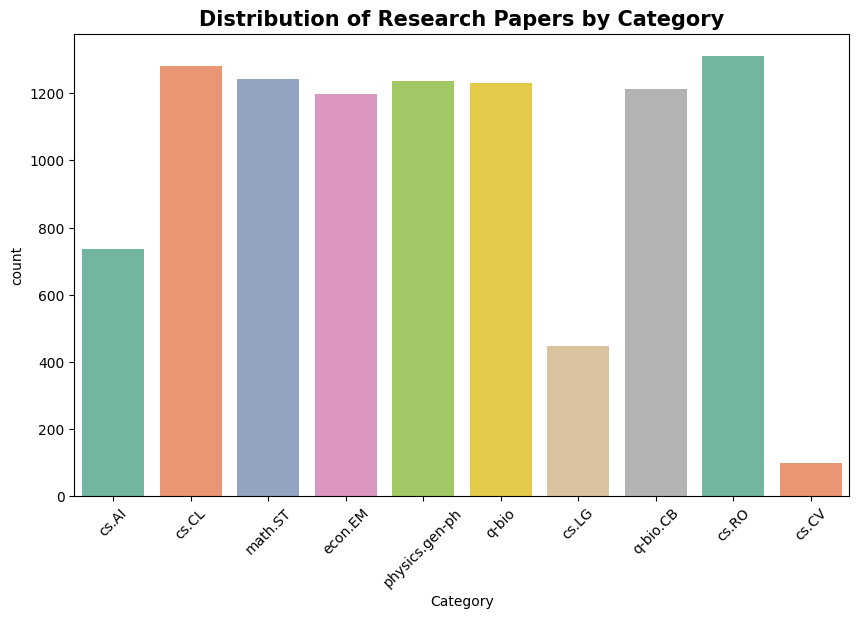

In [34]:
# 1. Category Distribution

plt.figure(figsize=(10,6))
ax = sns.countplot(x='Category', data=data, hue='Category', palette='Set2', legend=False)
plt.title('Distribution of Research Papers by Category', fontsize=15, weight= 'bold')
plt.xticks(rotation=45)

plt.show()

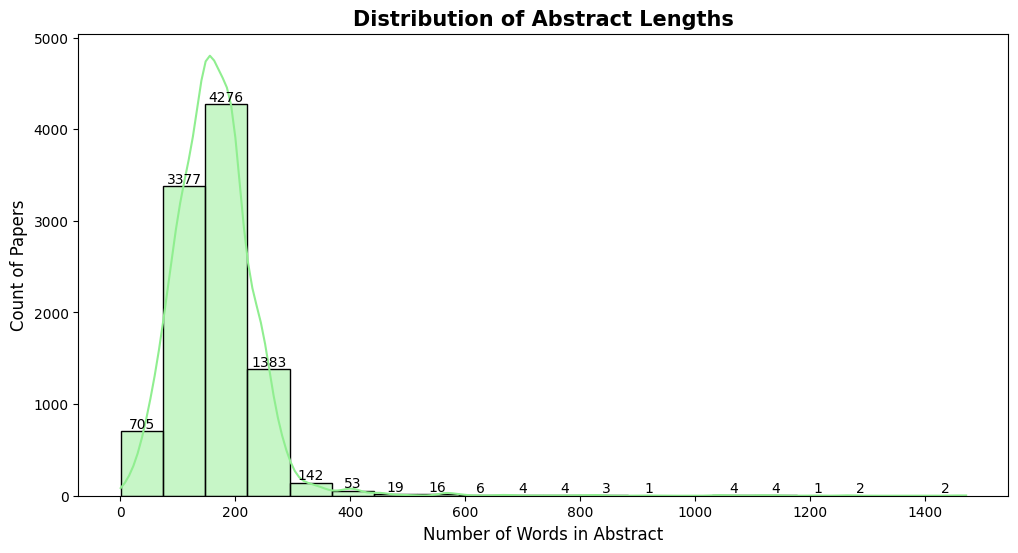

In [36]:
# 2. Abstract Length Distribution

data['Abstract Length'] = data['Abstract'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
ax = sns.histplot(data['Abstract Length'], kde=True, color='lightgreen', bins=20)
plt.title('Distribution of Abstract Lengths', fontsize=15, weight='bold')
plt.xlabel('Number of Words in Abstract', fontsize=12)
plt.ylabel('Count of Papers', fontsize=12)

for patch in ax.patches:
    if patch.get_height() > 0:  # To avoid annotations on empty bins
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        count = int(y)
        ax.annotate(count, (x, y), ha='center', va='bottom', fontsize=10)

plt.show()

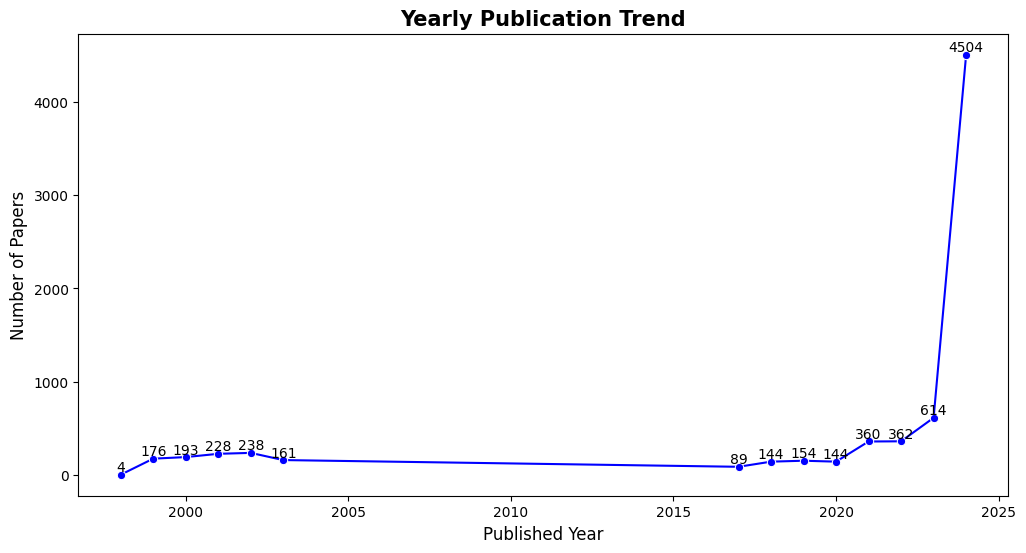

In [39]:
# 3. Yearly Publication Trend

filtered_data = data[data['Published Year'] != 0]
year_counts = filtered_data['Published Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='blue')
plt.title('Yearly Publication Trend', fontsize=15, weight='bold')
plt.xlabel('Published Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)

for x, y in zip(year_counts.index, year_counts.values):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10)
plt.show()

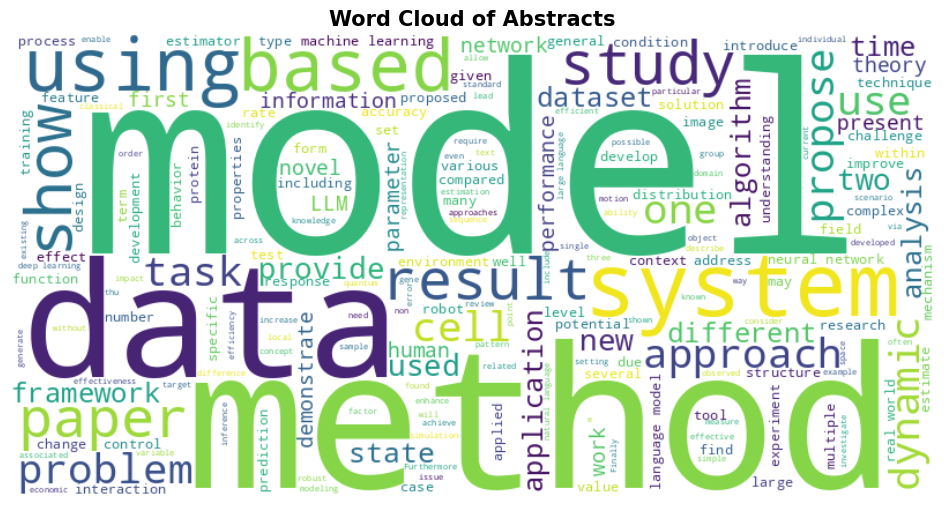

In [41]:
# 4. Abstract Word Cloud

from wordcloud import WordCloud
all_abstracts = " ".join(data['Abstract'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_abstracts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstracts', fontsize=15, weight='bold')
plt.show()

Now We will look into the word cloud for each category for detailed visual

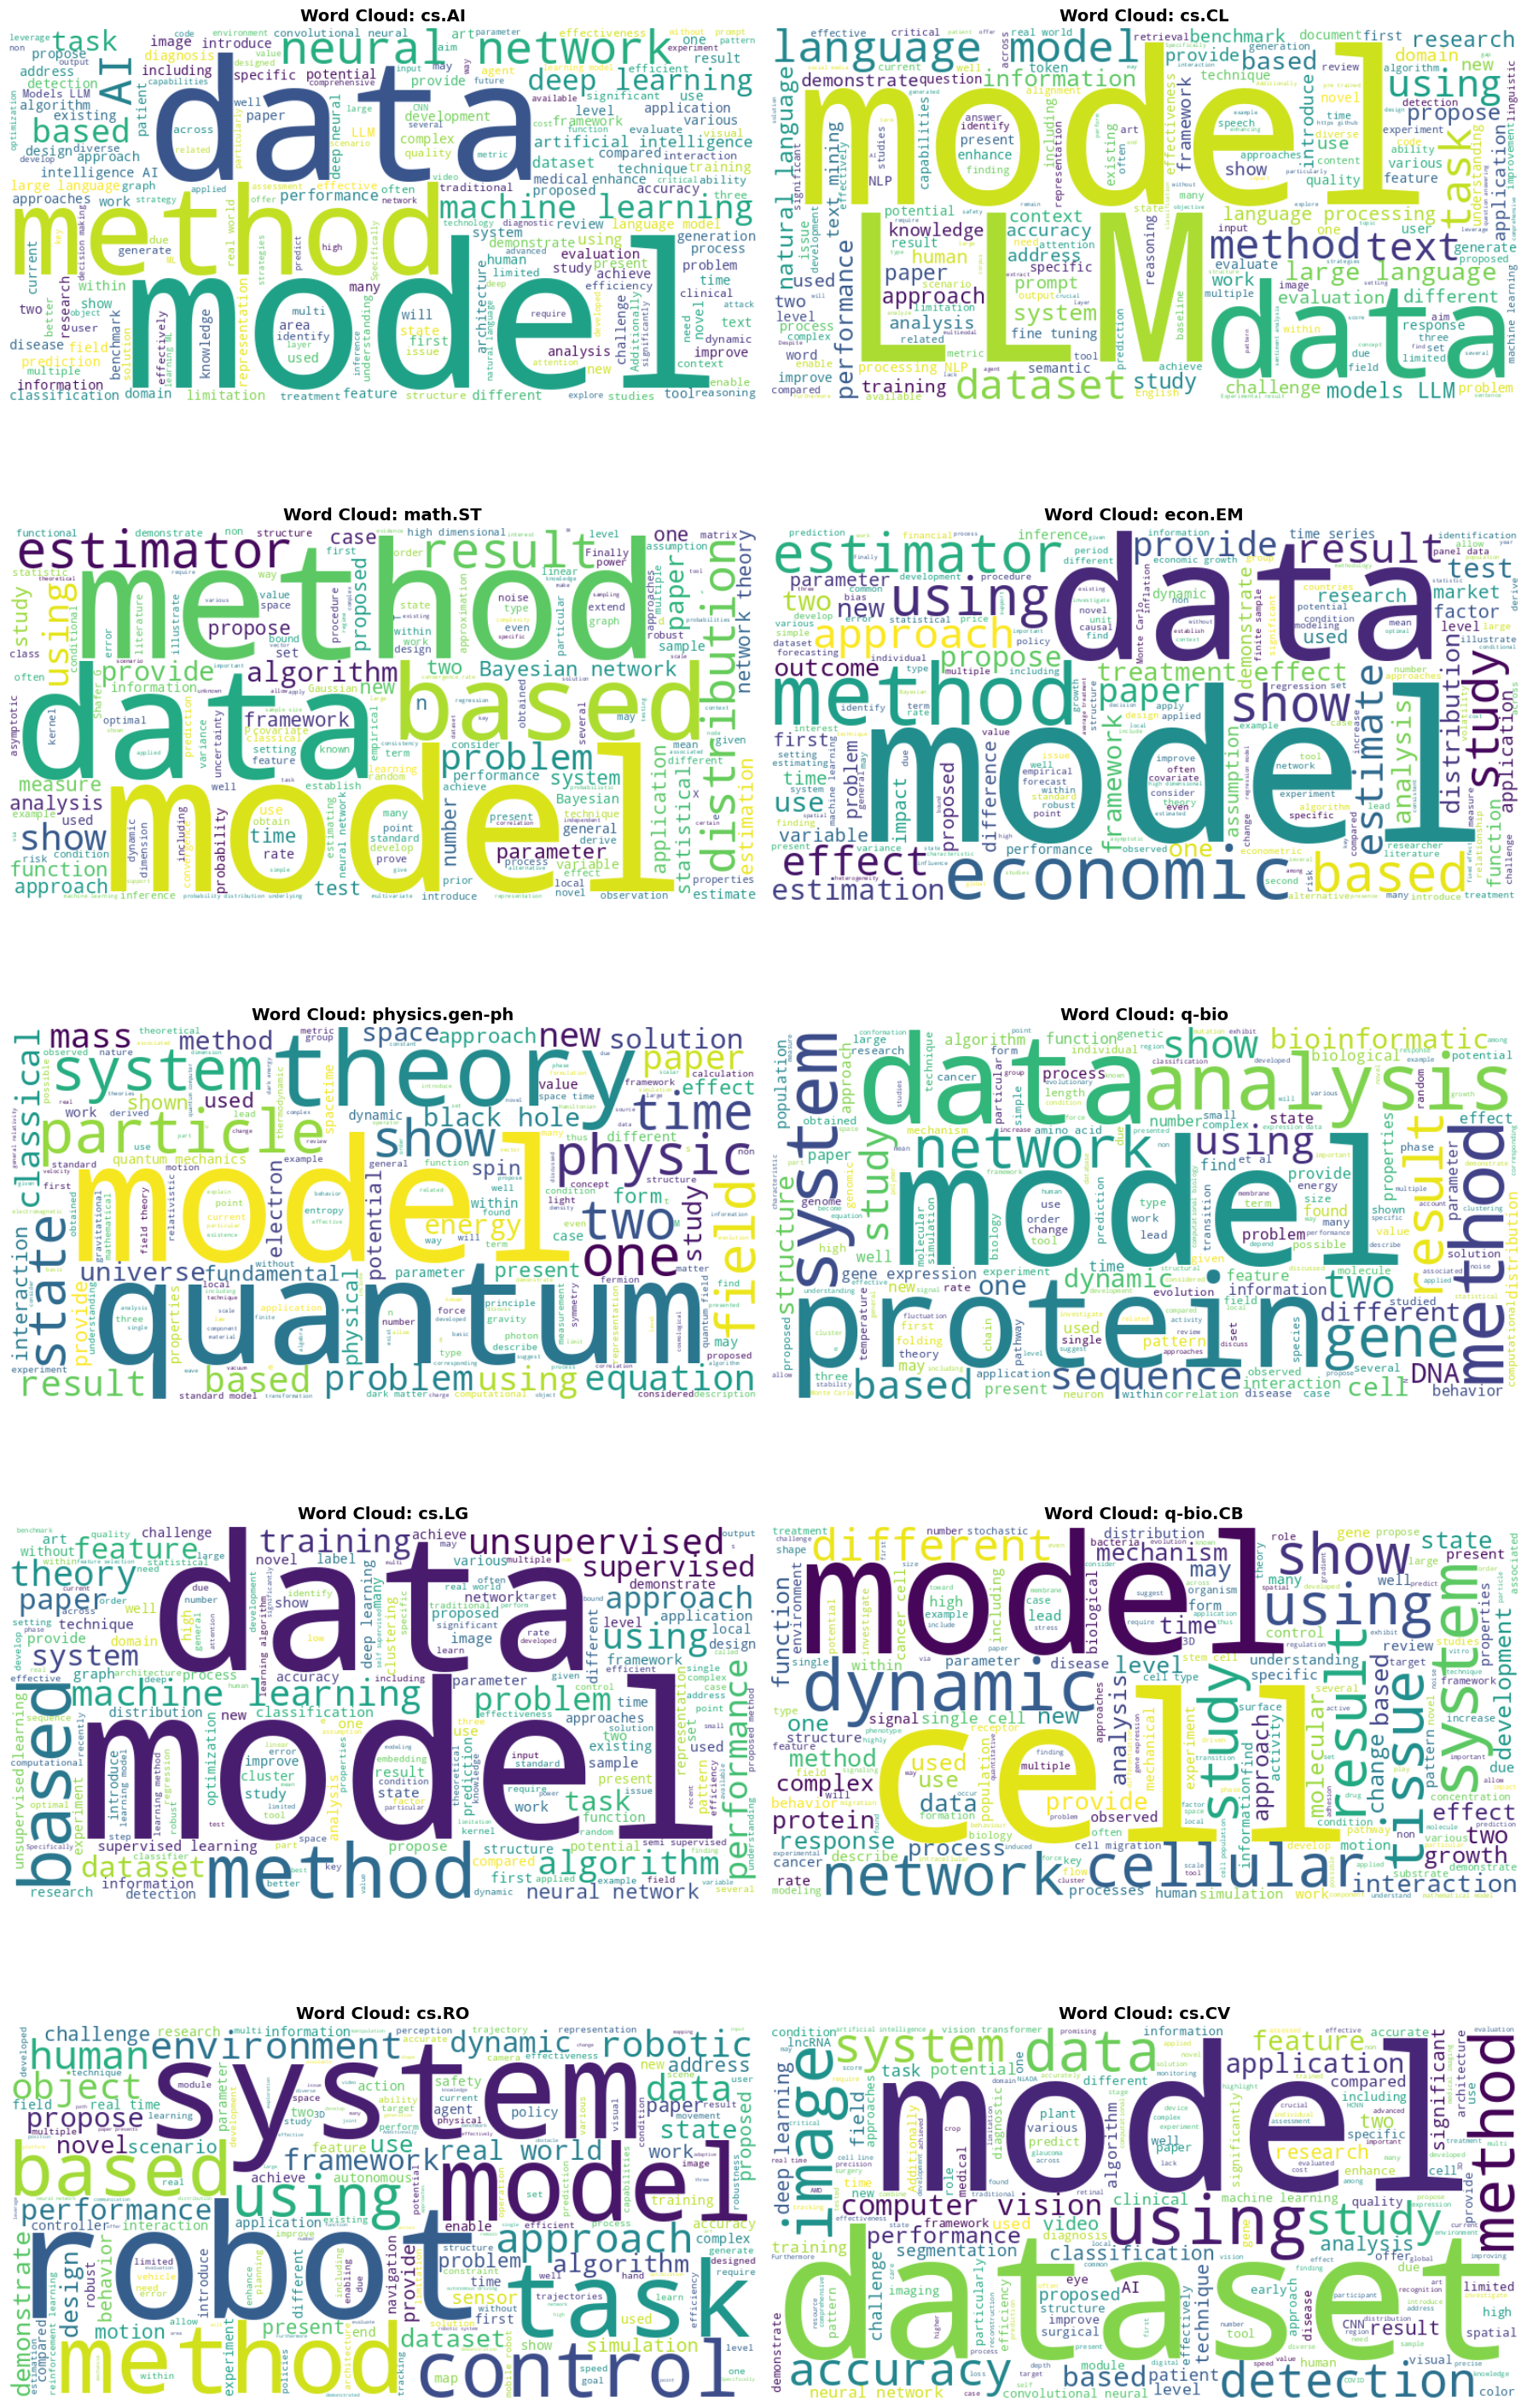

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

categories = data['Category'].unique()

n_cols = 2
n_rows = math.ceil(len(categories) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for idx, category in enumerate(categories):
    category_data = data[data['Category'] == category]
    all_abstracts = " ".join(category_data['Abstract'])

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_abstracts)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Word Cloud: {category}', fontsize=14, weight='bold')

for idx in range(len(categories), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [40]:
# Filter out papers with Published Year after 2014
count_after_2014 = data[data['Published Year'] != 'Unknown']['Published Year'].astype(int).gt(2014).sum()

print(f"Number of papers published after 2014: {count_after_2014}")

Number of papers published after 2014: 6371
